# 2. Automotive Cybersecurity Intrusion Detection with Cold Start

Too many tutorials, esp data science ones, start out with some toy applications and the really basic stuff, and then stalls out on the more complex real-world scenario. This one is going to be different. So, grab a cup of coffee before you continue :)

As automotive vehicles are increasingly connected, they face higher risk of being compromised. Especially, their in-vehicle networks are prone to attacks due to original designs with no security concerns in mind and one of the most common attacks is injecting messages to a vehicle’s CAN Bus.

In fact, this received [widespread media attention in 2015](https://www.wired.com/2015/07/hackers-remotely-kill-jeep-highway/) that a Senate bill was proposed in 2015 and [recently reintroduced in 2019](https://www.markey.senate.gov/news/press-releases/senators-markey-and-blumenthal-reintroduce-legislation-to-protect-cybersecurity-on-aircrafts-and-in-cars) to "ensure cybersecurity in increasingly computerized vehicles".

Similar threats exist for aircrafts, smart factories, smart buildings, and of course, the increasing number of IoT appliances. But let’s focus on automotive cybersecurity in this tutorial.

<img src="http://docs.arimo.com/H1ST_AI_Tutorial/img/cyberattacks.png" alt="Cyberattaks" />

Two of the proposed requirement in the SPY Car act are:
  * All  entry  points  to  the  electronic  systems  of  each  motor  vehicle  manufactured  for  sale  in  the  United  States  shall  be  equipped  with  reasonable  measures  to  protect  against hacking attacks
  * Any  motor  vehicle  manufactured  for  sale  in  the  United  States  that  presents  an  entry  point  shall  be  equipped  with  capabilities  to  immediately  detect,  report,  and  stop  attempts  to  intercept  driving data or control the vehicle

It is not obvious that such intrusion detection system (IDS) could work, but it turns out that with careful system design, we can construct it with Human1st.AI. The nature of CAN bus data and vehicle operations is that the normal traffic is highly regular (unlike an open node on the internet) and we can leverage this to build an IDS.

Let's dive in!

### 1a. CAN data basics

Let's familiarize ourselves with vehicle data.

Controller Area Network (CAN Bus) is a common in-vehicle network architecture. It was designed to avoid massive physical wires between Engine Control Units (ECUs) in a vehicle. A CAN packet (also called message)’s payload contains data from one or more ECUs which we refer to as sensors such as Car Speed, Steering Wheel’s Angle, Yaw Rate, Longitudinal Acceleration (Gx), Latitudinal Acceleration (Gy).

CAN Bus’ simple communication protocol makes it vulnerable to cyber-attacks due to security issues such as message broadcasting, no authentication, etc. Injection attacks are common to CAN Bus.

_**NOTE**: we're currently working to make available fully an equivalent dataset to the one used for this tutorial for download. For now the tutorial is read-only. Hold on tight!_

In [3]:
import pandas as pd
import numpy as np

In [4]:
DATA_LOCATION = "COMING-SOON"
df = pd.read_parquet('%s/train/attacks/20181113_Driver1_Trip1-0.parquet' % DATA_LOCATION)

df.head(20)

,Timestamp,SteeringAngle,CarSpeed,YawRate,Gx,Gy,Label
0,120.000001,12.3,NaN,NaN,NaN,NaN,Normal
1,120.012008,12.3,NaN,NaN,NaN,NaN,Normal
2,120.012052,NaN,NaN,0.197147,0.016671,-0.002896,Normal
3,120.024006,NaN,0.0,NaN,NaN,NaN,Normal
4,120.024007,12.3,NaN,NaN,NaN,NaN,Normal
5,120.024076,NaN,NaN,0.196988,0.016514,-0.003019,Normal
6,120.035987,NaN,NaN,0.196828,0.016357,-0.003141,Normal
7,120.035995,12.3,NaN,NaN,NaN,NaN,Normal
8,120.047985,NaN,NaN,0.196668,0.016200,-0.003264,Normal
9,120.047986,12.3,NaN,NaN,NaN,NaN,Normal


Note that the data has a particular rhythm to it: each non-NA CarSpeed or YawRate comes at a regular interval, and YawRate/Gx/Gy messages always come with each other. In technical parlance, these are 3 different CAN IDs with different message payloads.

### 1b. Simulating attacks

Now comes the hard & fun part, as we only have normal data. How can we develop an intrusion detection system?

The first natural step is to generate attack data. There are many ways to simulate such attacks but the cheapest method is simply to inject fake messages into the stored data stream.

A more realistic (and also more expensive) method to safely simulate attacks is to inject messages directly into the CAN bus while vehicle is stationary (engine on/transmission in park), or when vehicle is in motion in a controlled driving environment / test track [such as conducted by the NHTSA](https://rosap.ntl.bts.gov/view/dot/41006)

For convenience, we have provided the synthetic data. Let’s take a look at it!

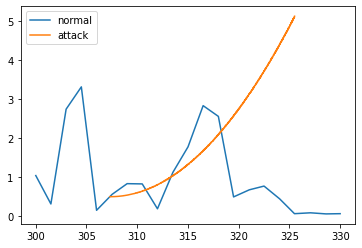

In [5]:
yr = df[(df.Timestamp > 300) & (df.Timestamp < 330)].dropna(subset=["YawRate"])
import matplotlib.pyplot as plt
att = yr[yr["Label"] == "Attack"]
normal = yr[yr["Label"] == "Normal"]
plt.plot(normal.Timestamp, normal.YawRate, label="normal")
plt.plot(att.Timestamp, att.YawRate, label="attack")
plt.legend()

The key question is can ML/AD system detect the injected messages from the normal ones?

## 2. Monolithic AD/ML Approaches and Why They are Unsatisfactory

Given the abundance of normal driving data, the problem naturally leads to an anomaly detection (AD) formulation. Let’s try some off-the-shell well-known methods for example Isolation Forest!

In theory, AD approach isn't affected by the Cold Start problem as training data is normal data only, and is hence we only need labels during evaluation of the intrusion detection system.

But will it work accurately enough? Let's try!

### 2a. A naive AD approach using IsolationForest

In [6]:
SENSORS = ["SteeringAngle", "CarSpeed", "YawRate", "Gx", "Gy"]

def compute_timediff_fillna(df):
    df = df.copy()
    for s in SENSORS:
        sensor_not_isna = df[~df[s].isna()]
        df["%s_TimeDiff" % s] = sensor_not_isna.Timestamp - sensor_not_isna.shift(1).Timestamp
    #print(df.head(20))

    for s in SENSORS:
        df[s] = df[s].fillna(method="ffill")
        df["%s_TimeDiff" % s] = df["%s_TimeDiff" % s].fillna(method="ffill")
    df.dropna(inplace=True)
    
    return df

df = pd.read_parquet("%s/train/attacks/20181113_Driver1_Trip1-0.parquet" % DATA_LOCATION)
df = compute_timediff_fillna(df)

Since we know that message timing is important, we should try to use those features in AD training. Can you spot see the difference between normal vs attack messages?

In [8]:
df_normal = df[df.Label == 'Normal']
df_normal.sample(5)

,Timestamp,SteeringAngle,CarSpeed,YawRate,Gx,Gy,Label,SteeringAngle_TimeDiff,CarSpeed_TimeDiff,YawRate_TimeDiff,Gx_TimeDiff,Gy_TimeDiff
310314,4651.368009,1.599472,53.262020,0.182120,0.036140,-0.104073,Normal,0.011984,0.024000,0.011943,0.011943,0.011943
219474,2693.819987,4.386408,80.489037,17.014353,-0.013549,-0.894699,Normal,0.011960,0.024007,0.010611,0.012002,0.012002
122275,2055.612012,4.283608,46.228298,1.063028,0.140284,-0.336961,Normal,0.012026,0.023980,0.000028,0.012044,0.012044
211727,2660.735991,4.903600,78.351761,1.506351,0.139225,-0.308420,Normal,0.011992,0.023992,0.011897,0.011897,0.011897
422124,6371.280012,15.572001,128.386993,4.926676,0.101201,3.130639,Normal,0.011982,0.024007,0.009422,0.011985,0.011985


In [9]:
df_attack = df[df.Label == 'Attack']
df_attack.sample(5)

,Timestamp,SteeringAngle,CarSpeed,YawRate,Gx,Gy,Label,SteeringAngle_TimeDiff,CarSpeed_TimeDiff,YawRate_TimeDiff,Gx_TimeDiff,Gy_TimeDiff
467242,7426.091304,1.01600,130.722397,40.000000,-0.173196,-0.056015,Attack,0.012003,0.024005,0.011349,0.011985,0.011985
64307,769.020065,2.41600,73.692062,0.446286,0.295156,0.314811,Attack,0.011996,0.024002,0.000009,0.000009,0.000009
208178,2647.740008,0.26960,79.171234,0.024701,-0.010674,0.148819,Attack,0.011999,0.023980,0.000007,0.000007,0.000007
282899,3998.520016,2.48938,57.042484,0.339417,0.352549,-0.127944,Attack,0.012006,0.024000,0.000003,0.000003,0.000003
255545,3470.351199,2.53278,0.000000,0.523398,0.003199,0.010731,Attack,0.011987,0.023975,0.011168,0.012055,0.012055


In [10]:
from sklearn.ensemble import IsolationForest
import sklearn.metrics

FEATURES = SENSORS + ["%s_TimeDiff" % s for s in SENSORS]

iforest = IsolationForest(n_estimators=500).fit(df_normal[FEATURES])

In [11]:
df2 = pd.read_parquet("%s/train/attacks/20181203_Driver1_Trip10-20.parquet" % DATA_LOCATION)
df2 = compute_timediff_fillna(df2)

ypred = iforest.predict(df2[FEATURES])
ypred = pd.Series(np.maximum(-ypred, 0))

cf = sklearn.metrics.confusion_matrix(df2.Label == "Attack", ypred)
print(cf) 

print("Accuracy = %s " % sklearn.metrics.accuracy_score(df2.Label =="Attack", ypred))

[[37486  6257]
 [ 4102  3858]]
Accuracy = 0.7996441212308764 


This is certainly not bad for a start. But the TPR and FPR is no where near what’s needed for deployment!

While there are a lot of exciting approaches for AD and sequential time-series data, including using RNN/LSTM/CNN, autoencoders, self-supervised learning, etc. The fundamental problem with AD is that it is hard to achieve high TPR while simultaneously achieving very low FPR.

Since AD after all, is a harder problem than supervised learning and while they are important parts of the tool box, we still need final human clearance to key system decisions.

### 2b. Machine teaching: leveraging ML to "program" a classifier by specifying human-generated outputs

If we zoom in, it is perhaps easier to see the zig-zag patterns of alternating real vs injected messages. It's clear that perhaps we can leverage a ML to classify these kinds of smooth vs zig-zag patterns.

After all, ML should excel at pattern recognition.

The significance of this approach is that it is much easier for human experts to synthesize the attack data than to write the detection program. And such is the promise of Software 2.0, but will it work?

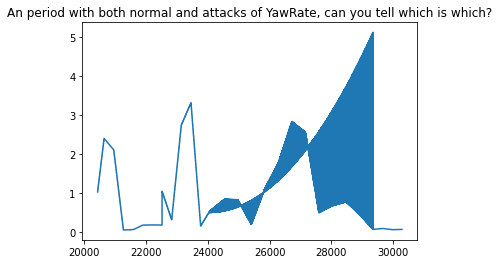

In [5]:
import matplotlib.pyplot as plt
df[(df.Timestamp >= 200) & (df.Timestamp <= 330)].YawRate.dropna().plot()
plt.title("An period with both normal and attacks of YawRate, can you tell which is which?")
plt.show()

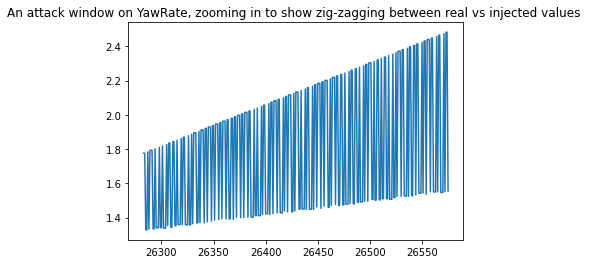

In [6]:
df[(df.Timestamp > 315) & (df.Timestamp < 316)].YawRate.dropna().plot()
plt.title("An attack window on YawRate, zooming in to show zig-zagging between real vs injected values ")
plt.show()

Let’s try a gradient-boosted trees firstly, e.g. sklearn’s HistGradientBoostingClassifier can work well on larger dataset before bringing out bigger guns.

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

gbc = HistGradientBoostingClassifier(max_iter=500).fit(df[FEATURES], df.Label == "Attack")

In [16]:
ypred = gbc.predict(df2[FEATURES])

cf = sklearn.metrics.confusion_matrix(df2.Label == "Attack", ypred)
print(sklearn.metrics.accuracy_score(df2.Label == "Attack", ypred))
print(cf)

print("Accuracy = %s " % sklearn.metrics.accuracy_score(df2.Label == "Attack", ypred))

0.8564686768659459
[[42191  1552]
 [ 5869  2091]]
Accuracy = 0.8564686768659459 


### 2c. Deep Learning and using a H1ST Model API, organizing, importing, saving & loading

We can bring out larger guns like Bidirectional LSTM or CNN or Transformers which can work well on pattern recognition problems on sequential data such as this one. One such model is available in the full tutorial source code package, and it can reach quite impressive accuracy.

Let's see how we could use it!

In [9]:
import h1st as h1
h1.init()

from AutomotiveCybersecurity.models.blstm_injection_msg_classifier import BlstmInjectionMsgClassifier

m = BlstmInjectionMsgClassifier()

A data-science project in H1ST.AI is designed to be a Python-importable package. You can create such a project using the `h1` command-line tool.

Organizing model code this way makes it easy to use as we will see. The Model API provides a unified workflow so that models can be used interactively in notebooks as well as in structured and complex projects as we shall see later.

Here, we call `h1.init()` to make sure we can import the package in our notebooks even when the package is not installed (as long as the notebooks are within the project folder structure).

It is a simple matter to import and train such organized `h1st.Model`, say on a small fraction of the data.

In [4]:
data = m.load_data(num_files=100)

prepared_data = m.prep_data(data)

m.train(prepared_data, epochs=10)

Epoch 1/10
     75/Unknown - 18s 246ms/step - loss: 0.4046 - accuracy: 0.8629
Epoch 00001: val_loss improved from inf to 0.38385, saving model to checkpoints/blstm_classif1.h5
75/75 [==============================] - 21s 274ms/step - loss: 0.4046 - accuracy: 0.8629 - val_loss: 0.3838 - val_accuracy: 0.8558
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8729
Epoch 00002: val_loss improved from 0.38385 to 0.37567, saving model to checkpoints/blstm_classif2.h5
75/75 [==============================] - 35s 467ms/step - loss: 0.3661 - accuracy: 0.8729 - val_loss: 0.3757 - val_accuracy: 0.8558
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8994
Epoch 00003: val_loss improved from 0.37567 to 0.21447, saving model to checkpoints/blstm_classif3.h5
75/75 [==============================] - 29s 393ms/step - loss: 0.2966 - accuracy: 0.8994 - val_loss: 0.2145 - val_accuracy: 0.9057
Epoch 4/10
75/75 [==================

As expected, powerful deep learning models can recognize these attack patterns well. (And we haven’t even trained the model on all the data and until fully converged.)

However, we must reckon that these models, after all, are recognizing attack patterns that humans are generating and injecting artificially. While this is convenient to generate output and train the detector program a la “Software 2.0”, for our situation, because the attacks are purely synthetic, we cannot be too sure that they are learning the right things and work robustly and can be trusted to deploy in the field. It’s best to employ them in the right deployment scope, namely useful pattern recognizers.

## 3. Using H1st.AI: Encoding Human Insights as a Model and Harmonizing Human + ML in a H1st.Graph

### 3a. Use case analysis: turning on safe-mode vs post-moterm analysis

The H1ST.AI approach to this problem begins by thinking about the end-users of the decision system, and their uses cases.

What are the use cases for such Automotive Cybersecurity system? We can envision two distinctive use cases:
  1. The onboard intrusion detection system can detect an attack event in realtime and set the car into a safe mode so that drivers can safely get to a safe location and not be stuck in the highway with malfunctioning cars.
  2. An security expert could review the attack in post-mortem mode, in which the IDS provides message-by-message attack vs normal classification.

For use case #1 "safe mode triggering by attack event detection", the ML requirement is that it has near-zero FPR. 

To give an example, each second might contain 100 of CAN messages per car. If we have a fleet with just 1000 cars, each driven 1h per day, then a FPR of 0.00001 at message-level still means that each day we have 0.00001 x 100msg x 3600s x 1000cars = 3600 false positive events per day!

Additionally, for deployment & anticipated regulatory purpose, the system should behave robustly and explainably. While explainability is a complex subject, we meant that one could anticipate the system’s behavior reasonably well, as well as for legal/regulation purposes. As we saw with iForest or GBM ML models, they don’t quite meet this requirement, as it is hard to explain precisely how these models classify attacks, even if they can achieve good accuracy.

For use case #2 "post-morterm analysis", it turns out that the requirement is very different. Some FPR could be traded off for higher TPR for post-mortem. And the system might not need to highly explainable as it is after all the jobs of the security experts to analyze the attacks in depth and make the final decisions.

### 3b. Problem (re)formulation into H1st.AI Graph

We reformulate the problem into the form of a decision graph, where the outermost flow detects attack events and corresponding yes branches handles message classification. For this tutorial we focus on injection attacks which are most common in the wild (we will revisit this later).

The graph looks like this.

<img src="http://docs.arimo.com/H1ST_AI_Tutorial/img/graph2.png" alt="automotive cybersecurity solution graph"/>

### 3c. Encoding human insights for event detection as a H1st.Model

Remember when we start analyzing the CAN dataset, we have remarked that the normal data is highly regular, especially in terms of the message frequency for each CAN ID.

It turns out that using message frequency statistics for injection event detection is highly accurate for safe-mode use cases (high TPR, low FNR). This surprising fact was first pointed out by the original CAN bus hackers Chris Valasek and Charlie Miller in the seminal white paper [Adventures in Automotive Networks and Control Units](https://ioactive.com/pdfs/IOActive_Adventures_in_Automotive_Networks_and_Control_Units.pdf).

> It is pretty straightforward to detect the attacks discussed in this paper.  They always involve either sending new, unusual CAN packets or flooding the CAN bus with common packets... Additionally, the frequency of normal CAN packets is very predictable... Therefore we propose that a system can detect CAN anomalies based on the known frequency of certain traffic and can alert a system or user if frequency levels vary drastically from what is well known. 

Using H1ST, we can encode insights of such “human” models and use them just like ML models. An h1.Model is essentially anything that can predict. H1ST provides tools to help automate their saving and loading, too, easing the way for using them in an integrated decision system.

In a H1ST project structure, we typically organize this under `models` directory, e.g. the content of `models/msg_freq_event_detector.py` looks like this.

In [10]:
SENSORS = ["SteeringAngle", "CarSpeed", "YawRate", "Gx", "Gy"]

class MsgFreqEventDetectorModel(h1.Model):
    def load_data():
        pass
    
    def train(data):
        pass
    
    def predict(self, data):
        present_size=0.1
        df = data['df']
        window_starts = data["window_starts"]
        window_results = []
        for window_start in window_starts:
            w_df = df[(df.Timestamp >= window_start) & (df.Timestamp < window_start + WINDOW_SIZE)]
            results = {}
            for _, sensor in enumerate(SENSORS):
                w_df_sensor = w_df.dropna(subset=[sensor])
                max_normal_message_freq = self.stats.at['max', sensor]
                msg_freq = len(w_df_sensor)
                if msg_freq > (max_normal_message_freq+1): #or min_timediff < min_normal_timediff:
                    results[sensor] = 1
                else:
                    results[sensor] = 0
                
                # print((window_start, sensor, msg_freq, max_normal_message_freq, results[sensor]))
                
                results["WindowInAttack"] = any(results.values())
            results["window_start"] = window_start # information for down-stream
            window_results.append(results)
        return {"event_detection_results": window_results}

Now let's import and train this `MsgFreqEventDetectorModel`.

In [11]:
from AutomotiveCybersecurity.models.msg_freq_event_detector import MsgFreqEventDetectorModel

m = MsgFreqEventDetectorModel()

You can look inside the model file `models/msg_freq_event_detector.py` to see the details of training. It’s quite simple, looping through a number of files to compute window statistics such as how many msg per CAN ID are found & what’s the min & max and percentile values.


In [ ]:
data = m.load_data(num_samples=20)
m.train(data)

In [87]:
m.stats

,SteeringAngle,CarSpeed,YawRate,Gx,Gy
count,23767.000000,23767.000000,23767.000000,23767.000000,23767.000000
mean,33.053309,16.526486,33.053267,33.053267,33.053267
std,0.425629,0.499308,0.426474,0.426474,0.426474
min,32.000000,16.000000,32.000000,32.000000,32.000000
25%,33.000000,16.000000,33.000000,33.000000,33.000000
50%,33.000000,17.000000,33.000000,33.000000,33.000000
75%,33.000000,17.000000,33.000000,33.000000,33.000000
max,34.000000,17.000000,34.000000,34.000000,34.000000


The nice things about h1st.Model that we can easily save/load them. By default, the "model", "stats" and "metrics" properties are persisted and they support a variety of flavors & data structure.

In [88]:
m.persist()

2020-08-11 00:32:41,488 INFO h1st.model_repository: Saving stats property...


'01EFE6YZWFD2DF2GBQSNQ6E666'

### 3d. Working with H1st Graph

Let's now make some event-level predictions.

Note that since the model was persisted using H1st model repo, this means that we can easily come back to a notebooks and/or scripts and load the trained model or computed statistics.

Importantly, H1st allows much speedier integration into a Graph (and later deployment, too).

In [12]:
from AutomotiveCybersecurity.graph import WindowGenerator
from AutomotiveCybersecurity.models.msg_freq_event_detector import MsgFreqEventDetectorModel

graph = h1.Graph()
graph.start()\
     .add(WindowGenerator())\
     .add(MsgFreqEventDetectorModel().load())
graph.end()

import glob
fs = glob.glob("/Users/aht/Documents/autocyber/13Prius/predict_data/add/YawRate/*.csv")
print(fs[0])
df = pd.read_csv(fs[0])
df.columns = ['Timestamp', 'Label', 'CarSpeed', 'SteeringAngle', 'YawRate', 'Gx', 'Gy']

results = graph.predict({"df": df})
results.keys()

2020-08-14 22:23:15,192 INFO h1st.model_repository.model_repository: Loading version 01EFQN6454J0AHK60F81PXV8CB ....


/Users/aht/Documents/autocyber/13Prius/predict_data/add/YawRate/Attack_YR_Cycle_Add_back_01_030_1to1_D_01.csv


dict_keys(['df', 'window_starts', 'event_detection_results'])

And we should see that starting we can detect attacks starting at Timestamp 604.3105000000011

In [11]:
[x for x in results["event_detection_results"] if x["WindowInAttack"]][:5]

[{'SteeringAngle': 0,
  'WindowInAttack': True,
  'CarSpeed': 0,
  'YawRate': 1,
  'Gx': 1,
  'Gy': 1,
  'window_start': 604.4104999999997},
 {'SteeringAngle': 0,
  'WindowInAttack': True,
  'CarSpeed': 0,
  'YawRate': 1,
  'Gx': 1,
  'Gy': 1,
  'window_start': 604.8104999999997},
 {'SteeringAngle': 0,
  'WindowInAttack': True,
  'CarSpeed': 0,
  'YawRate': 1,
  'Gx': 1,
  'Gy': 1,
  'window_start': 605.2104999999997},
 {'SteeringAngle': 0,
  'WindowInAttack': True,
  'CarSpeed': 0,
  'YawRate': 1,
  'Gx': 1,
  'Gy': 1,
  'window_start': 605.6104999999997},
 {'SteeringAngle': 0,
  'WindowInAttack': True,
  'CarSpeed': 0,
  'YawRate': 1,
  'Gx': 1,
  'Gy': 1,
  'window_start': 606.0104999999996}]

### 3e. Adding a message classifier, harmonizing human + ML models in the graph

For message-level classification we can simply bring back our gradient-boosted trees which did a decent job of recognizing injection messages. (Integrating sequence model such as Bidirectional LSTM is left as an exercise for the reader).

For convenient, we've re-orgarnized it as a H1st.Model, ready for use. The content of `models/gradient_boosting_msg_classifier.py` looks like this.

In [13]:
FEATURES = SENSORS + ["%s_TimeDiff" % s for s in SENSORS]

class GradientBoostingMsgClassifierModel(h1.Model):
    def load_data(self, num_samples=None):
        return util.load_data_daic(num_samples, shuffle=True)

    def prep_data(self, data):
        # concat multiple files into separate training/test pd.DataFrame
        def concat_processed_files(files):
            dfs = []
            for f in files:
                z = pd.read_csv(f)
                z.columns = ['Timestamp', 'Label', 'CarSpeed', 'SteeringAngle', 'YawRate', 'Gx', 'Gy',]
                z = util.compute_timediff_fillna(z)
                dfs.append(z)
            df2 = pd.concat(dfs)
            return df2
        return {
            "train_attack_df": concat_processed_files(data["train_attack_files"]),
            "test_attack_df": concat_processed_files(data["test_attack_files"])
        }

    def train(self, prepared_data):
        df = prepared_data["train_attack_df"]
        from sklearn.experimental import enable_hist_gradient_boosting
        from sklearn.ensemble import HistGradientBoostingClassifier
        X = df[FEATURES]
        y = df.Label == "Tx"
        self.model = HistGradientBoostingClassifier(max_iter=500).fit(X, y)

    def evaluate(self, data):        
        df = prepared_data["test_attack_df"]
        ypred = self.model.predict(df[FEATURES])
        import sklearn.metrics
        cf = sklearn.metrics.confusion_matrix(df.Label == "Tx", ypred)
        acc = sklearn.metrics.accuracy_score(df.Label == "Tx", ypred)
        print(cf)
        print("Accuracy = %.4f" % acc)
        self.metrics = {"confusion_matrix": cf, "accuracy": acc}
    
    def predict(self, data):
        df = data["df"].copy()
        df = util.compute_timediff_fillna(df)
        df['MsgIsAttack'] = 0
        df['WindowInAttack'] = 0
        for event_result in data["event_detection_results"]:
            if event_result['WindowInAttack']:
                # print("window %s in attack: event_result = %s" % (event_result['window_start'], event_result))
                in_window = (df.Timestamp >= event_result['window_start']) & (df.Timestamp < event_result['window_start'] + WINDOW_SIZE)
                w_df = df[in_window]
                ypred = self.model.predict(w_df[FEATURES])
                df.loc[in_window, "WindowInAttack"] = 1
                df.loc[in_window, "MsgIsAttack"] = ypred.astype(int)
                return {"injection_window_results": df}

In [14]:
from AutomotiveCybersecurity.models.gradient_boosting_msg_classifier import GradientBoostingMsgClassifierModel

m2 = GradientBoostingMsgClassifierModel()
data = m2.load_data(num_files=50)

In [17]:
prepared_data = m2.prep_data(data)

len train_attack_df = 242167
len test_attack_df = 243774


In [18]:
m2.train(prepared_data)

In [19]:
m2.evaluate(prepared_data)

[[203136   2966]
 [ 13066  24606]]
Accuracy = 0.9342


In [20]:
m2.persist()

2020-08-14 22:21:08,989 INFO h1st.model_repository.model_repository: Saving metrics property...
2020-08-14 22:21:08,990 INFO h1st.model_repository.model_repository: Saving model property...


'01EFR910BWJEPT466ARTNCC18E'

In [16]:
class NoOp(h1.Action):
    def call(self, command, inputs):
        pass

graph = h1.Graph()
graph.start()\
     .add(WindowGenerator())\
     .add(h1.Decision(MsgFreqEventDetectorModel().load(), decision_field="WindowInAttack"))\
     .add(yes=GradientBoostingMsgClassifierModel().load(),
          no=NoOp())
graph.end()

results = graph.predict({"df": df})
results.keys()

2020-08-14 22:23:40,159 INFO h1st.model_repository.model_repository: Loading version 01EFQN6454J0AHK60F81PXV8CB ....
2020-08-14 22:23:40,164 INFO h1st.model_repository.model_repository: Loading version 01EFR910BWJEPT466ARTNCC18E ....


dict_keys(['df', 'window_starts', 'event_detection_results', 'injection_window_results'])

Now let's evaluate the whole graph, especially focusing on the event-level TPR & FPR since they are crucial in the safe-mode deployment use case.

In [17]:
from AutomotiveCybersecurity.util import evaluate_event_graph

evaluate_event_graph(graph, data['test_attack_files'])

Event-level confusion matrix
[[1155    0]
 [   0 1300]]
Event TPR = 1.0000, FPR = 0.0000


(1155, 0, 0, 1300)

Woa! We ran through all 400ms windows in the test samples and got event-level FPR=0.0% with zero false positives! (Note that this is still a subsample of the data, but once you've tried it on the full dataset the results should be the same: zero false positive at event-level.)

The message-level accuracy should be nearly the same because we used the same classifier. However the decomposition leads to separation of concerns and requirement for these two use cases. We're much more comfortable with the solution now both in terms of accuracy as well as robustness and explainability.

Another significance worth pointing out here is that we get multiple output streams from H1st.Graph: event-level outputs and msg-level outputs, exactly what we need for two different use cases we highlighted: safe-mode triggering and post-mortem analysis.

## Summary & Further Resources

That was a long tutorial! But not a trivial

To recap, the H1ST.AI principles & ideas we've learned:
  * Leverage use-case analysis to decompose problems and adopt different models at the right level of abstractions
  * Encoding human experience as a model
  * Combine human experience and data-driven insights to work harmoniously in a H1st Graph

Most importantly, we have used H1ST.AI to tackle a real-world challenging automotive cybersecurity problem, for which attack event labels are not available to start with, hence solving the Cold Start problem. 

It is important to stress that this is still a toy example IDS and much more is needed to handle attacks (e.g. replacement attacks where a whole ECU can be compromised & normal messages silenced and there won’t be a zig-zag pattern) and of course on-device vs cloud deployment, OTA updates, etc. But it is clear adopting H1ST.AI makes the problem much more tractable and explainable.

H1ST.AI framework further provides productivity tools for a team of Data Scientists and domain experts to collaborate on such complex software projects. Especially, we’ve seen our own productivity vastly when moving from a spaghetti code jungle of ML to a more principled H1ST project structure and make use of H1ST Model API & repository as well as Graph.

Interested? For further resources:
  * Check out our documentation site!
  * Contribute! Star/fork our Github repo, we're looking forward to your contribution to move real-world industrial AI head and to drive "industrial processes and machines and robots"!